
Data Size: 10
NN Start Distance: 2.90, Compute Time: 0.66 sec


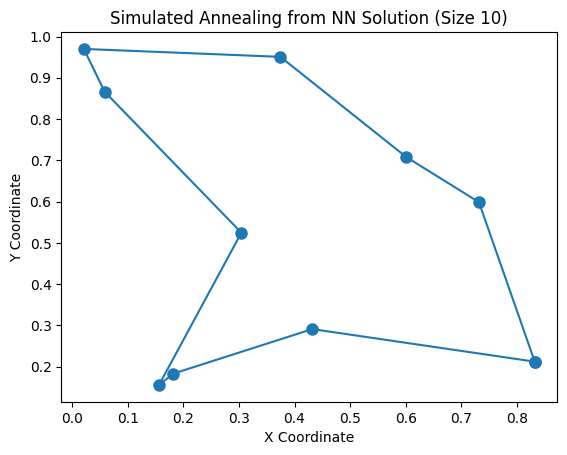

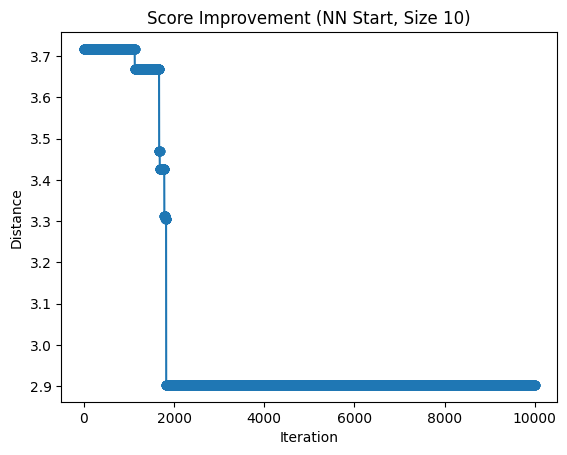

Random Start Distance: 2.90, Compute Time: 0.15 sec


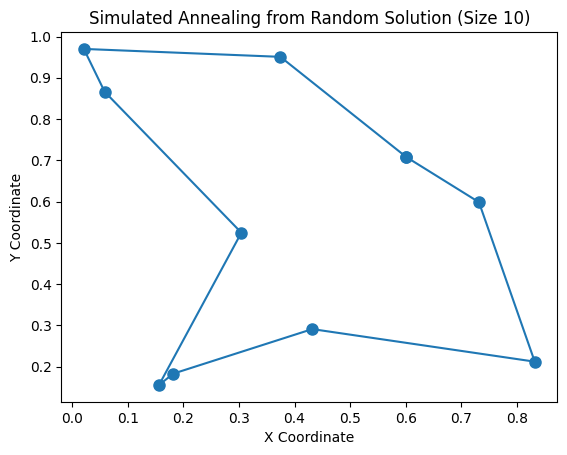

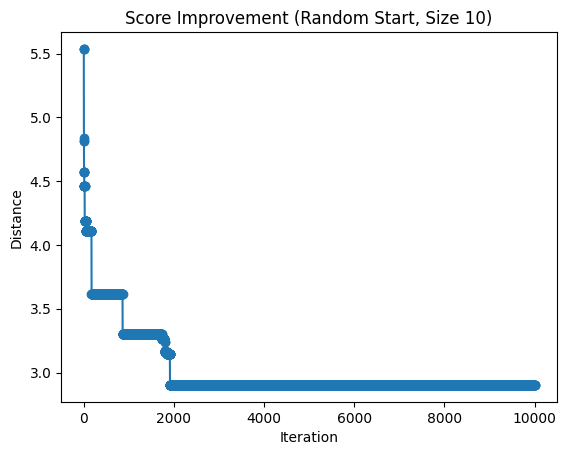


Data Size: 20
NN Start Distance: 3.87, Compute Time: 0.15 sec


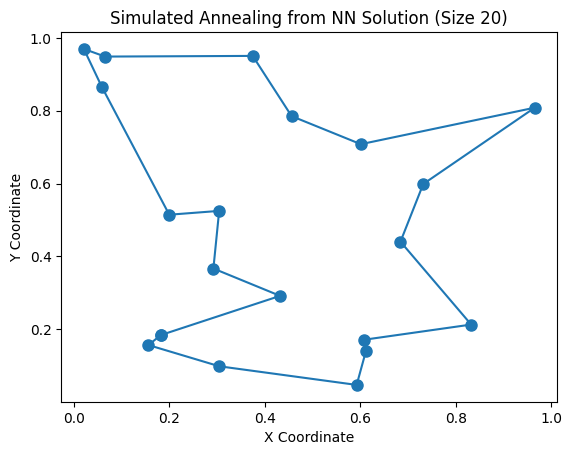

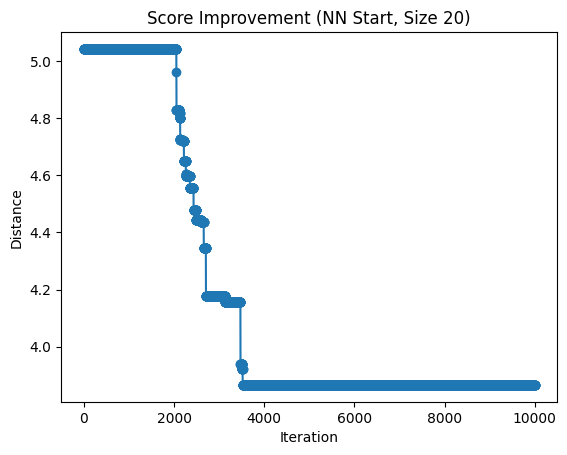

Random Start Distance: 4.28, Compute Time: 0.31 sec


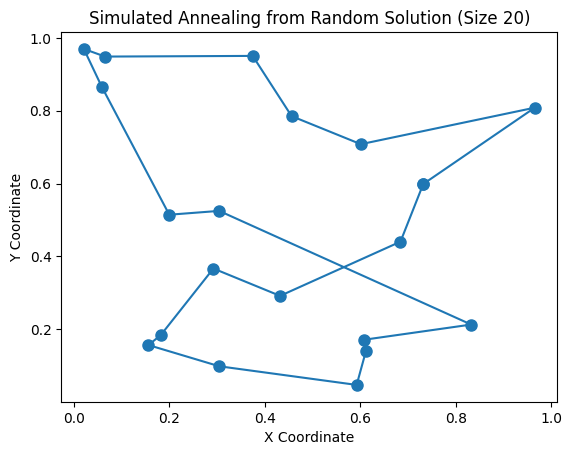

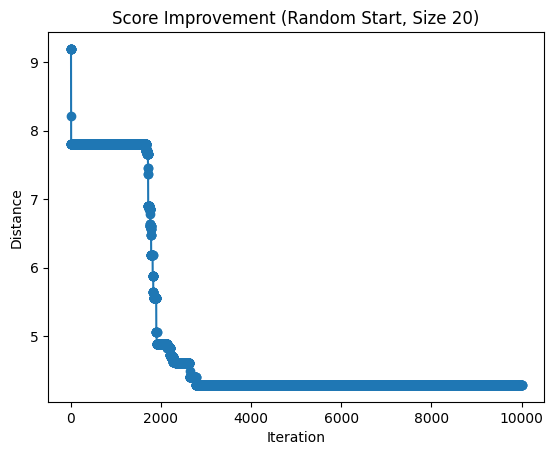


Data Size: 50
NN Start Distance: 7.38, Compute Time: 0.32 sec


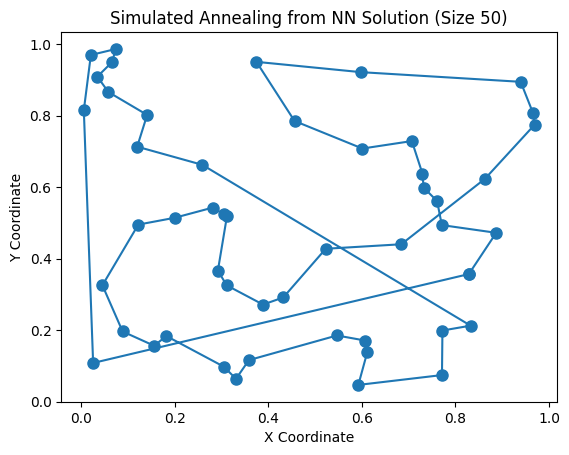

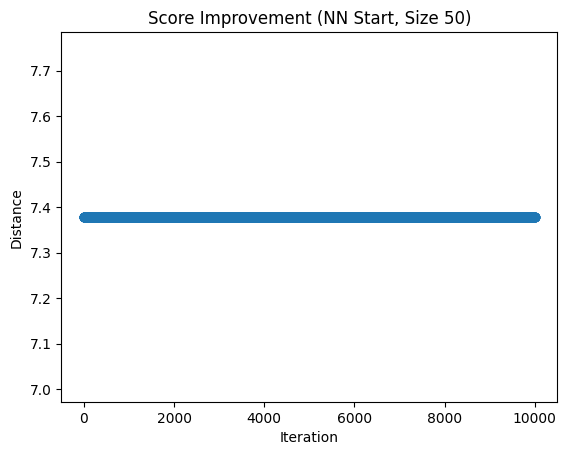

Random Start Distance: 8.01, Compute Time: 0.30 sec


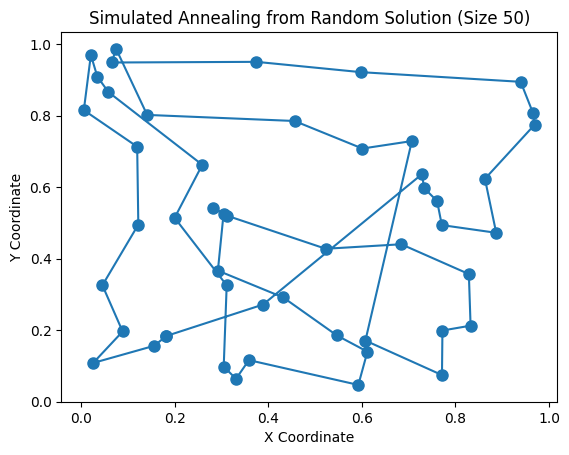

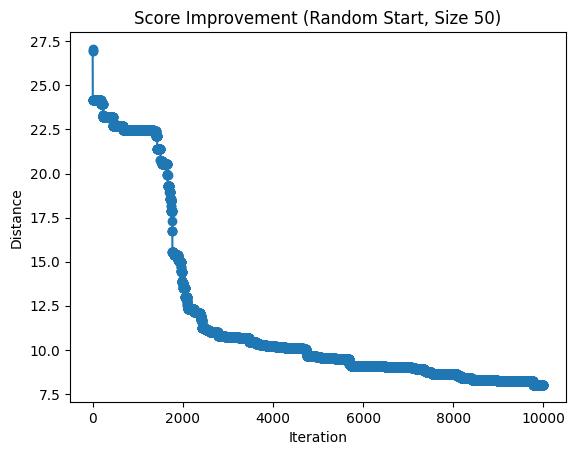


Data Size: 100
NN Start Distance: 9.90, Compute Time: 0.38 sec


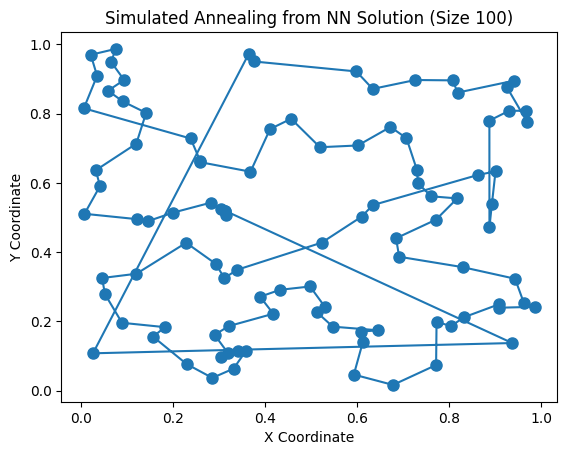

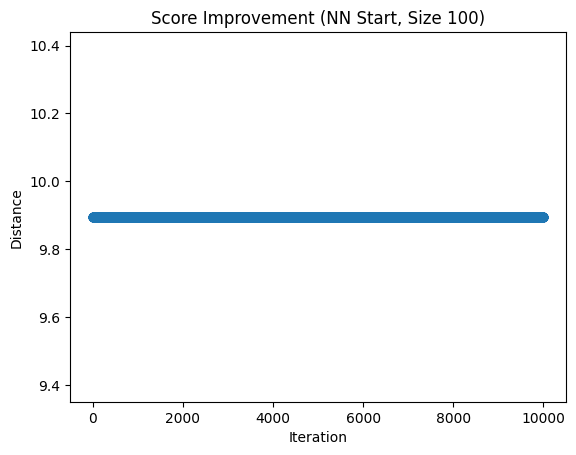

Random Start Distance: 16.06, Compute Time: 0.73 sec


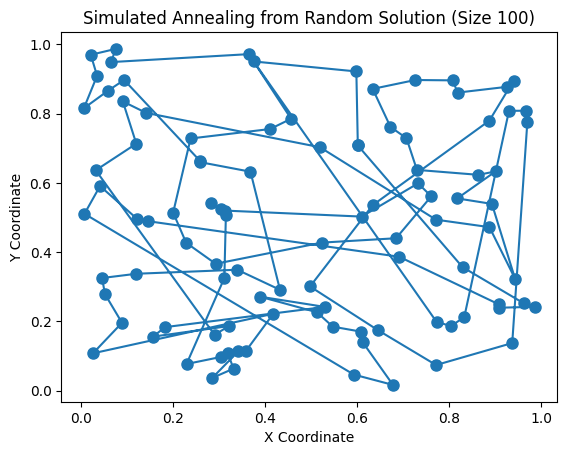

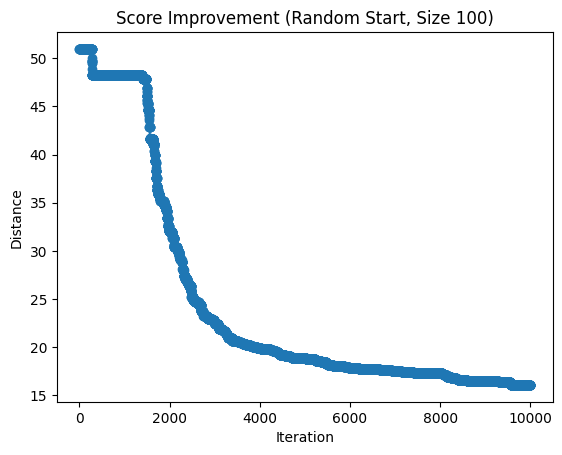

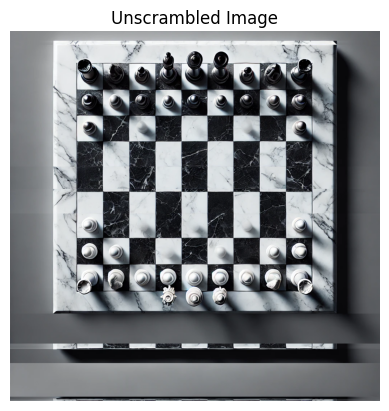

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image

# Function to calculate the total distance of a TSP path
def calculate_distance(path, distance_matrix):
    return sum(distance_matrix[path[i - 1], path[i]] for i in range(len(path)))

# Nearest Neighbor heuristic
def nearest_neighbor(distance_matrix):
    n = len(distance_matrix)
    unvisited = set(range(n))
    current_city = np.random.choice(n)
    path = [current_city]
    unvisited.remove(current_city)

    while unvisited:
        next_city = min(unvisited, key=lambda city: distance_matrix[current_city, city])
        path.append(next_city)
        unvisited.remove(next_city)
        current_city = next_city

    return path

# Simulated Annealing for TSP
def simulated_annealing(distance_matrix, initial_path, initial_temperature, cooling_rate, max_iterations):
    current_path = initial_path.copy()
    current_distance = calculate_distance(current_path, distance_matrix)
    best_path = current_path.copy()
    best_distance = current_distance
    temperature = initial_temperature

    distances = [current_distance]

    for iteration in range(max_iterations):
        # Create a new path by swapping two cities
        new_path = current_path.copy()
        i, j = np.random.choice(len(new_path), size=2, replace=False)
        new_path[i], new_path[j] = new_path[j], new_path[i]
        
        new_distance = calculate_distance(new_path, distance_matrix)
        
        # Acceptance probability
        if new_distance < current_distance or np.random.rand() < np.exp((current_distance - new_distance) / temperature):
            current_path = new_path
            current_distance = new_distance
            
            # Update best path
            if current_distance < best_distance:
                best_path = current_path
                best_distance = current_distance
        
        # Cool down
        temperature *= cooling_rate
        distances.append(best_distance)

    return best_path, best_distance, distances

# Generate random TSP distance matrix
def generate_distance_matrix(num_cities, seed=42):
    np.random.seed(seed)
    coordinates = np.random.rand(num_cities, 2)
    distance_matrix = np.sqrt(((coordinates[:, np.newaxis, :] - coordinates[np.newaxis, :, :]) ** 2).sum(axis=2))
    return distance_matrix, coordinates

# Plot TSP path
def plot_tsp_path(path, coordinates, title):
    path_coordinates = coordinates[path + [path[0]]]  # To complete the loop
    plt.figure()
    plt.plot(path_coordinates[:, 0], path_coordinates[:, 1], 'o-', markersize=8)
    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

# Plot score improvement over time
def plot_score_improvement(distances, title):
    plt.figure()
    plt.plot(distances, marker='o')
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.show()

# Unscramble Image Rows using TSP
def unscramble_image(image_path, initial_temperature, cooling_rate, max_iterations):
    # Load the image
    image = Image.open(image_path)
    scrambled_array = np.array(image)
    num_rows = scrambled_array.shape[0]

    # Create distance matrix based on row differences
    distance_matrix = np.zeros((num_rows, num_rows))
    for i in range(num_rows):
        for j in range(num_rows):
            distance_matrix[i, j] = np.sum((scrambled_array[i] - scrambled_array[j]) ** 2)

    # Solve using Nearest Neighbor and Simulated Annealing
    nn_path = nearest_neighbor(distance_matrix)
    best_path, _, _ = simulated_annealing(distance_matrix, nn_path, initial_temperature, cooling_rate, max_iterations)

    # Reconstruct the image using the best path
    unscrambled_array = scrambled_array[best_path]
    unscrambled_image = Image.fromarray(unscrambled_array)

    # Show the unscrambled image
    plt.figure()
    plt.imshow(unscrambled_image)
    plt.title("Unscrambled Image")
    plt.axis('off')
    plt.show()

# Parameters
initial_temperature = 1000
cooling_rate = 0.995
max_iterations = 10000

# Testing on different data sizes
data_sizes = [10, 20, 50, 100]
for num_cities in data_sizes:
    print(f"\nData Size: {num_cities}")
    distance_matrix, coordinates = generate_distance_matrix(num_cities)

    # Start from NN heuristic solution
    nn_start_time = time.time()
    nn_path = nearest_neighbor(distance_matrix)
    nn_path, nn_distance, nn_distances = simulated_annealing(distance_matrix, nn_path, initial_temperature, cooling_rate, max_iterations)
    nn_compute_time = time.time() - nn_start_time
    print(f"NN Start Distance: {nn_distance:.2f}, Compute Time: {nn_compute_time:.2f} sec")
    plot_tsp_path(nn_path, coordinates, f"Simulated Annealing from NN Solution (Size {num_cities})")
    plot_score_improvement(nn_distances, f"Score Improvement (NN Start, Size {num_cities})")

    # Start from random initial solution
    random_start_time = time.time()
    random_path = list(np.random.permutation(num_cities))
    random_path, random_distance, random_distances = simulated_annealing(distance_matrix, random_path, initial_temperature, cooling_rate, max_iterations)
    random_compute_time = time.time() - random_start_time
    print(f"Random Start Distance: {random_distance:.2f}, Compute Time: {random_compute_time:.2f} sec")
    plot_tsp_path(random_path, coordinates, f"Simulated Annealing from Random Solution (Size {num_cities})")
    plot_score_improvement(random_distances, f"Score Improvement (Random Start, Size {num_cities})")

image_path = 'hw_10_2_shuffled.png'  
unscramble_image(image_path, initial_temperature, cooling_rate, max_iterations)

